Demographics Data:
       ID  Amzius   Ugis  Svoris    KMI
0  NCF201    26.0  168.7    73.2  25.56
1  NCF202    28.0  171.0    55.0  18.30
2  NCF203    22.0  170.0    73.2  25.40
3  NCF204    34.0  174.0    59.0  19.50
4  NCF205    20.0  161.3    61.8  23.20

Alpha Metrics Data:
                                      Participant_ID  Alpha_Mean_Power  \
0  NCF_201_R2256_imp_ch_flt1-45_flt50_rejectedart...          0.437231   
1  NCF_202_R2256_imp_ch_flt1-45_flt50_rejectedart...          0.596187   
2  NCF_204_R2256_imp_ch_flt1-45_flt50_rejectedart...          0.119732   
3  NCF_205_R2256_imp_ch_flt1-45_flt50_rejectedart...          0.968375   
4  NCF_206_R2256_imp_ch_flt1-45_flt50_rejectedart...          0.846919   

   Alpha_Sum_Power  
0      2229.879639  
1      3040.553467  
2       610.633667  
3      4938.712891  
4      4319.288086  


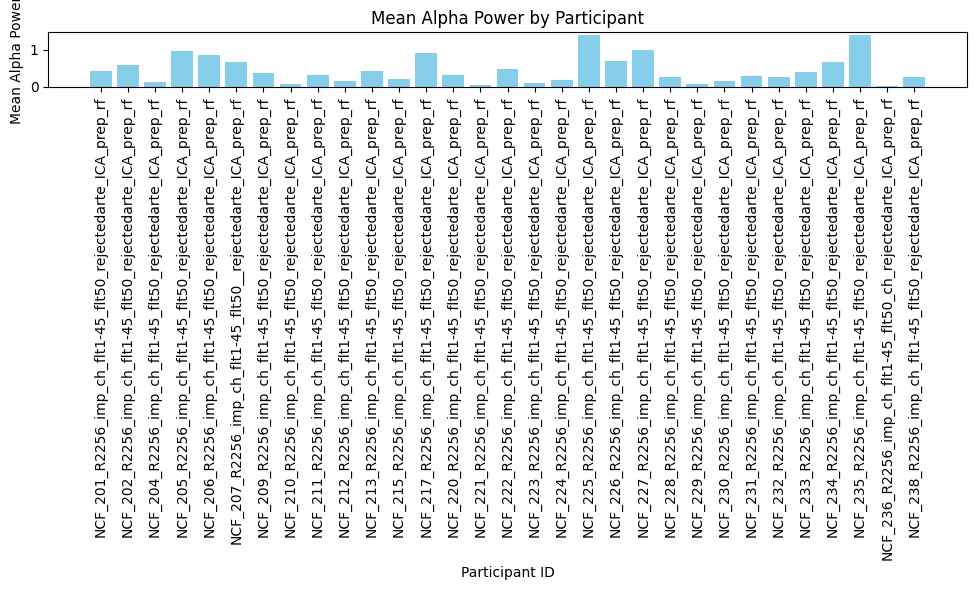

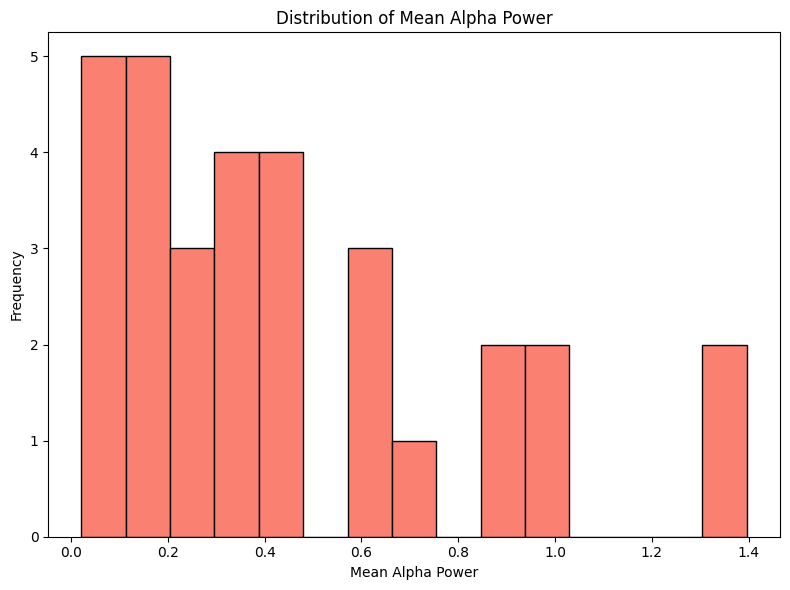

Results saved to eeg_analysis_results.xlsx.


In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# === Step 1: Load Demographics Data ===
# Specify the path to the demographics Excel file.
demographics_path = 'dem_info.xlsx'  # Replace with your file path
demographics_df = pd.read_excel(demographics_path)

# Display the demographics dataframe to verify
print("Demographics Data:")
print(demographics_df.head())

# === Step 2: Load and Process EEG Data ===
# Path to the single .mat file
mat_path = r'C:\Users\donat\Pratybos naujas\psd_and_freq_for_FOOOF_moterys_NFC.mat'  # Correct file path

# Initialize lists to store extracted alpha metrics
participant_ids = []
alpha_means = []
alpha_sums = []

# Load the .mat file
mat_data = loadmat(mat_path)

# Extract the 'psd' data structure
psd_data = mat_data['psd']

# Function to pad arrays to match lengths
def pad_arrays(freq, spect):
    if len(freq) > len(spect):
        # Pad spect to match freq length
        spect = np.pad(spect, (0, len(freq) - len(spect)), mode='constant', constant_values=0)
    elif len(spect) > len(freq):
        # Pad freq to match spect length
        freq = np.pad(freq, (0, len(spect) - len(freq)), mode='constant', constant_values=0)
    return freq, spect

# Loop through all participants in the psd structure
for i in range(psd_data.shape[1]):
    participant_data = psd_data[0, i]
    
    # Extract relevant fields
    freq = participant_data['freq'].squeeze()  # Frequency array
    spect = participant_data['spect'].squeeze()  # Power density spectrum array
    participant_id = participant_data['ID'].squeeze()  # Participant ID
    
    # Pad freq and spect to match lengths
    freq, spect = pad_arrays(freq, spect)
    
    # Filter for alpha band (8-12 Hz)
    alpha_mask = (freq >= 8) & (freq <= 12)
    alpha_freq = freq[alpha_mask]
    alpha_power = spect[alpha_mask]
    
    # Calculate metrics for alpha band
    alpha_mean = np.mean(alpha_power)
    alpha_sum = np.sum(alpha_power)
    
    # Append to lists
    participant_ids.append(participant_id)
    alpha_means.append(alpha_mean)
    alpha_sums.append(alpha_sum)

# Create a DataFrame for alpha metrics
alpha_df = pd.DataFrame({
    'Participant_ID': participant_ids,
    'Alpha_Mean_Power': alpha_means,
    'Alpha_Sum_Power': alpha_sums
})

# Convert Participant_ID column to string to ensure consistency
alpha_df['Participant_ID'] = alpha_df['Participant_ID'].astype(str)

# Display the alpha metrics to verify
print("\nAlpha Metrics Data:")
print(alpha_df.head())

# === Step 3: Visualize Alpha Band Metrics ===
# Bar chart of alpha mean power
plt.figure(figsize=(10, 6))
plt.bar(alpha_df['Participant_ID'], alpha_df['Alpha_Mean_Power'], color='skyblue')
plt.title('Mean Alpha Power by Participant')
plt.xlabel('Participant ID')
plt.ylabel('Mean Alpha Power')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('alpha_mean_power.png')
plt.show()

# Histogram of alpha power density
plt.figure(figsize=(8, 6))
plt.hist(alpha_means, bins=15, color='salmon', edgecolor='black')
plt.title('Distribution of Mean Alpha Power')
plt.xlabel('Mean Alpha Power')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('alpha_power_distribution.png')
plt.show()

# === Step 4: Export Results ===
# Combine demographics and alpha metrics into one Excel file
output_path = 'eeg_analysis_results.xlsx'
with pd.ExcelWriter(output_path) as writer:
    demographics_df.to_excel(writer, sheet_name='Demographics', index=False)
    alpha_df.to_excel(writer, sheet_name='Alpha Metrics', index=False)

print(f"Results saved to {output_path}.")


In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from fooof import FOOOF

# === Step 1: Load Demographics Data ===
# Specify the path to the demographics Excel file.
demographics_path = 'dem_info.xlsx'  # Replace with your file path
demographics_df = pd.read_excel(demographics_path)

# Display the demographics dataframe to verify
print("Demographics Data:")
print(demographics_df.head())

# === Step 2: Load and Process EEG Data ===
# Path to the single .mat file
mat_path = r'C:\Users\donat\Pratybos naujas\psd_and_freq_for_FOOOF_moterys_NFC.mat'  # Correct file path

# Initialize lists to store extracted alpha metrics
participant_ids = []
alpha_means = []
alpha_sums = []

# Load the .mat file
mat_data = loadmat(mat_path)

# Extract the 'psd' data structure
psd_data = mat_data['psd']

# Define the common frequency array for resampling
common_freq = np.linspace(1, 30, 300)  # Example frequency array

# Function to resample spect to match common_freq
def resample_spect(freq, spect, common_freq):
    f = interp1d(freq, spect, kind='linear', fill_value='extrapolate')
    spect_resampled = f(common_freq)
    return spect_resampled

# Initialize lists to collect all resampled spect arrays for averaging
all_spect_arrays = []

# Loop through all participants in the psd structure
for i in range(psd_data.shape[1]):
    participant_data = psd_data[0, i]
    
    # Extract relevant fields
    freq = participant_data['freq'].squeeze()  # Frequency array
    spect = participant_data['spect'].squeeze()  # Power density spectrum array
    participant_id = participant_data['ID'].squeeze()  # Participant ID
    
    # Resample spect to match common_freq
    spect_resampled = resample_spect(freq, spect, common_freq)
    
    # Collect resampled spect arrays
    all_spect_arrays.append(spect_resampled)
    
    # Filter for alpha band (8-12 Hz)
    alpha_mask = (common_freq >= 8) & (common_freq <= 12)
    alpha_freq = common_freq[alpha_mask]
    alpha_power = spect_resampled[alpha_mask]
    
    # Calculate metrics for alpha band
    alpha_mean = np.mean(alpha_power)
    alpha_sum = np.sum(alpha_power)
    
    # Append to lists
    participant_ids.append(participant_id)
    alpha_means.append(alpha_mean)
    alpha_sums.append(alpha_sum)

# Convert lists to numpy arrays
all_spect_arrays = np.array(all_spect_arrays)

# Calculate the average spectrum across all participants
average_spect = np.mean(all_spect_arrays, axis=0)

# Create a DataFrame for alpha metrics
alpha_df = pd.DataFrame({
    'Participant_ID': participant_ids,
    'Alpha_Mean_Power': alpha_means,
    'Alpha_Sum_Power': alpha_sums
})

# Convert Participant_ID column to string to ensure consistency
alpha_df['Participant_ID'] = alpha_df['Participant_ID'].astype(str)

# Display the alpha metrics to verify
print("\nAlpha Metrics Data:")
print(alpha_df.head())

# === Step 3: Fit Power Spectrum Using FOOOF ===
# Create a FOOOF object with the adjusted peak width lower bound
freq_resolution = np.mean(np.diff(common_freq))
peak_width_limits = [2 * freq_resolution, np.inf]
fooof = FOOOF(peak_width_limits=peak_width_limits)

# Fit the model to the data
fooof.fit(common_freq, average_spect)

# Get the results of the FOOOF fit
results = fooof.get_results()
aperiodic_params = results.aperiodic_params
peak_params = results.peak_params
r_squared = results.r_squared
error = results.error

# === Step 4: Save Results to Excel ===
# Combine the results into a DataFrame
foof_results_df = pd.DataFrame({
    'Frequency (Hz)': common_freq,
    'Average Power Density': average_spect,
    'Aperiodic Offset': [aperiodic_params[0]] * len(common_freq),
    'Aperiodic Exponent': [aperiodic_params[1]] * len(common_freq),
    'R-squared': [r_squared] * len(common_freq),
    'Error': [error] * len(common_freq)
})

# Save the results to an Excel file
output_path = 'fooof_analysis_results.xlsx'
with pd.ExcelWriter(output_path) as writer:
    demographics_df.to_excel(writer, sheet_name='Demographics', index=False)
    alpha_df.to_excel(writer, sheet_name='Alpha Metrics', index=False)
    foof_results_df.to_excel(writer, sheet_name='FOOOF Results', index=False)

print(f"FOOOF results saved to {output_path}.")

# === Step 5: Plot the Averaged Power Spectrum and the Fitted Model ===
plt.figure(figsize=(10, 6))

# Plot the actual power spectrum (log scale)
plt.plot(common_freq, np.log10(average_spect), label='Average Power Spectrum', color='blue')

# Plot the FOOOF model fit (log scale)
fooof.plot()

# Customize the plot
plt.title('Averaged Power Spectrum with FOOOF Model Fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power/Frequency')
plt.legend()
plt.tight_layout()

# Save and display the plot
plt.savefig('fooof_power_spectrum_fit_adjusted.png')
plt.show()


Demographics Data:
       ID  Amzius   Ugis  Svoris    KMI
0  NCF201    26.0  168.7    73.2  25.56
1  NCF202    28.0  171.0    55.0  18.30
2  NCF203    22.0  170.0    73.2  25.40
3  NCF204    34.0  174.0    59.0  19.50
4  NCF205    20.0  161.3    61.8  23.20


IndexError: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 300

In [21]:
!pip install PyPDF2
!pip 

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
